<a href="https://colab.research.google.com/github/manneryzach/mcgill-physics-hack2021/blob/main/chnaldi_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The sound of geometry
Chnaldi figures are obtained when a certain piece of material, usually circular of square, is vibrating in a particular mode. The nodes and anti-nodes 
formed by the oscillation make complex but symmetrical patterns all over the surface that can be seen if a fine grain material is sprinkled on top of the surface.

These calculations can also be applied to the case of a vibrating membrane, or drum. Changing the shape of the drum will change it's harmonics and hence it's sound. Our project explores how different shaped drums produce different harmonics and different sounds when struck.

To get those fancy patterns, our code is solving the Helmholtz equation with Dirichlet boundary conditions: 


\begin{cases} \nabla^2 u(\vec{r}) + \lambda^2 u(\vec{r})=0 \quad on \  \Omega\ \\ u(\vec{r})=0 \quad on \ \partial \Omega \end{cases}




Which is derived by separation of variables on the wave equation: 

\begin{align}
\nabla^2 \psi(t,\vec{r})=\frac{1}{v^2}\frac{\partial^2 \psi(t,\vec{r})}{\partial^2 t} \\ 
\psi(t,\vec{r})=\phi(t)u(\vec{r}) \\
\Rightarrow \ \ \nabla^2 \phi u = \frac{1}{v^2}\partial^2_t \phi u \\
\frac{1}{u}\nabla^2 u=\frac{1}{v^2}\frac{1}{\phi}\partial_t^2 \phi = -\lambda^2
\end{align}

# Packages & Dependencies


In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

# Imports

In [18]:

from dolfin import *
from mshr import *
import numpy as np
from ufl import inner, grad, dx
import matplotlib.pyplot as plt

# Solver


In [ ]:
def generate_mesh_from_coords(coords, resolution):

    # convert array of coords to Dolfin point types
    points = []
    for coord in coords:
        points.append(Point(coord[0], coord[1]))

    domain = Polygon(points)
    mesh = generate_mesh(domain, resolution)

    return mesh

def eigenpair_solver(mesh, n_eig):
    # Function space
    V = FunctionSpace(mesh, 'Lagrange', 1)

    # Boundary conditions
    boundary_mesh = BoundaryMesh(mesh, "exterior")

    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, 0, boundary)

    # Test/Trial functions
    u_h = TrialFunction(V)
    v = TestFunction(V)

    # For variationnal problem
    a = inner(grad(u_h), grad(v)) * dx
    b = inner(u_h, v) *dx
    dummy = inner(1., v) * dx

    # Assemble system
    asm = SystemAssembler(b, dummy, bc)
    B = PETScMatrix()
    asm.assemble(B)

    diag_value = 1e6

    A = PETScMatrix()
    assemble(a, tensor=A)
    dummy_vec = assemble(dummy)

    bc.zero(A)
    bc.zero_columns(A, dummy_vec, diag_value)


    # Solve
    solver = SLEPcEigenSolver(A, B)

    solver.parameters['solver'] = 'krylov-schur'
    solver.parameters['spectrum'] = 'smallest magnitude'
    solver.parameters['problem_type'] = 'gen_hermitian'
    solver.parameters['tolerance'] = 1e-10

    solver.solve(n_eig)

    w, v = [], []

    for i in range(solver.get_number_converged()):
        r, _, rv, _ = solver.get_eigenpair(i)
        w.append(r)

        u = Function(V)
        u.vector()[:] = rv

        v.append(u)

    w = np.array(w)

    return w, v

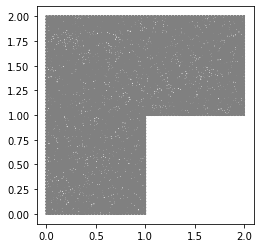

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


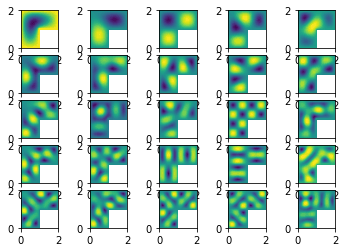

In [19]:
test_points = [ [0.,0.], [1.,0.], [1.,1.], [2.,1.,], [2.,2.], [0.,2.], [0.,0.]]

N = 60
lx = 0.2
ly = 0.1
lz = 1.0
# testmesh = UnitSquareMesh(100,100)
testmesh = generate_mesh_from_coords(test_points, 50)
plot(testmesh)
plt.show()

eigenvals, v = eigenpair_solver(testmesh, 25)

for i in range(0, 25):
    plt.subplot(5, 5, i+1)

    plot(v[i])

plt.show()

# Results
